
# Import libraries, preprocess data (cleaning, encoding, balancing with SMOTE), split into train/test sets, and train/evaluate models with performance visualization.

Original columns: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')
Columns after removing 'SEX': Index(['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


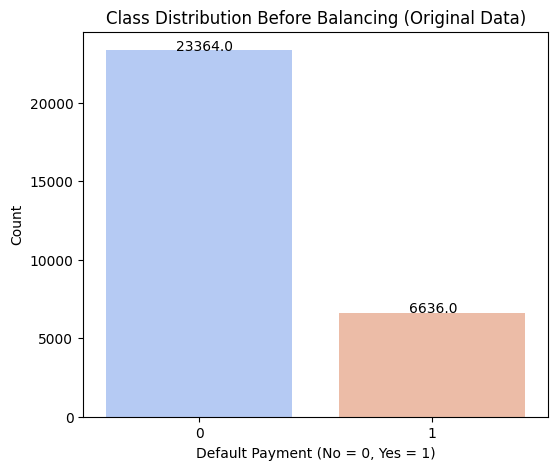

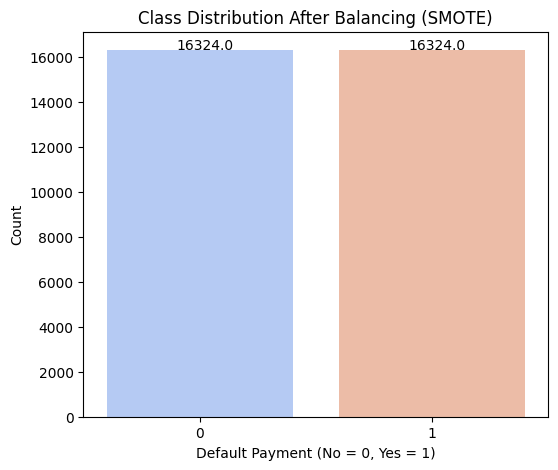

Training XGBoost...


C:\Users\Sufiyan Ahmed\PycharmProjects\internship\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:20:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost:

              precision    recall  f1-score   support

          No       0.85      0.87      0.86      7040
         Yes       0.49      0.45      0.47      1960

    accuracy                           0.78      9000
   macro avg       0.67      0.66      0.67      9000
weighted avg       0.77      0.78      0.78      9000



In [1]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Import the CSV file
df = pd.read_csv('Client_Data.csv')

# Print the original columns
print("Original columns:", df.columns)

# Remove the 'SEX' column
df = df.drop(columns=['SEX'])
df = df.drop(columns=['ID'])

# Print the columns after removing 'SEX'
print("Columns after removing 'SEX':", df.columns)

# Removing any leading or trailing spaces from column names
df.columns = df.columns.str.strip()
# Renaming the column
df.rename(columns={'default payment next month': 'default_payment'}, inplace=True)
df.replace({'default_payment' : {1 : 'Yes', 0 : 'No'}}, inplace = True)
# Replacing 'MARRIAGE' column values (1: Married, 2: Single, 3: Others)
df.replace({'MARRIAGE': {1: 'Married', 2: 'Single', 3: 'Others'}}, inplace=True)

# Replacing 'EDUCATION' column values (1: Graduate School, 2: University, 3: High School, 4: Others)
df.replace({'EDUCATION': {1: 'Graduate School', 2: 'University', 3: 'High School', 4: 'Others'}}, inplace=True)
# Ensuring all values in 'MARRIAGE' and 'EDUCATION' columns are strings before applying LabelEncoder
df['MARRIAGE'] = df['MARRIAGE'].astype(str)
df['EDUCATION'] = df['EDUCATION'].astype(str)


# Encoding categorical variables using Label Encoding
label_encoder = LabelEncoder()

# Encoding 'MARRIAGE' column to numeric values
df['MARRIAGE'] = label_encoder.fit_transform(df['MARRIAGE'])  # Mapping 'Married', 'Single', 'Others' to numbers

# Encoding 'EDUCATION' column to numeric values
df['EDUCATION'] = label_encoder.fit_transform(df['EDUCATION'])  # Mapping 'Graduate School', 'University', 'High School', 'Others' to numbers
# Encoding the target variable 'default_payment' to numeric values (0 for 'No', 1 for 'Yes')
df['default_payment'] = label_encoder.fit_transform(df['default_payment'])  # 'No' = 0, 'Yes' = 1

# Split the dataset into features (X) and target variable (y)
X = df.drop(columns=['default_payment'])  # Features
y = df['default_payment']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Plotting class distribution before balancing
plt.figure(figsize=(6,5))
sns.countplot(x='default_payment', data=df, palette='coolwarm')
plt.title('Class Distribution Before Balancing (Original Data)')
plt.xlabel('Default Payment (No = 0, Yes = 1)')
plt.ylabel('Count')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 10))
plt.show()

# Plotting class distribution after balancing (SMOTE)
plt.figure(figsize=(6,5))
sns.countplot(x='default_payment', data=pd.DataFrame({'default_payment': y_train_resampled}), palette='coolwarm')
plt.title('Class Distribution After Balancing (SMOTE)')
plt.xlabel('Default Payment (No = 0, Yes = 1)')
plt.ylabel('Count')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 10))
plt.show()

# Initialize the model
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Training and evaluating models
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)  # Train the model
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)  # For 'Yes' use the default label 1
    recall = recall_score(y_test, y_pred)  # For 'Yes' use the default label 1
    f1 = f1_score(y_test, y_pred)  # For 'Yes' use the default label 1
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
      
    # Print classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))
plt.show()

In [2]:
# Importing necessary libraries
from imblearn.over_sampling import SMOTE
from collections import Counter

# Checking the class distribution in the target variable before balancing
print("Class distribution before balancing:", Counter(y))

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Checking the class distribution after balancing
print("Class distribution after balancing:", Counter(y_resampled))


Class distribution before balancing: Counter({0: 23364, 1: 6636})
Class distribution after balancing: Counter({1: 23364, 0: 23364})


# Trains and evaluates an XGBoost classifier with custom parameters and threshold, outputs evaluation metrics and feature importance visualization.

C:\Users\Sufiyan Ahmed\PycharmProjects\internship\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Testing with the following parameters:
scale_pos_weight = 3.5, threshold = 0.65, max_depth = 5, learning_rate = 0.01
n_estimators = 175, subsample = 0.5, colsample_bytree = 0.8
reg_alpha = 0.01, reg_lambda = 0.1
The accuracy on train data is 0.781
The accuracy on test data is 0.817
The precision on test data is 0.621
The recall on test data is 0.409
The f1 on test data is 0.493
The roc_score on test data is 0.777
Classification Report for XGBoost on Test Data:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7040
           1       0.62      0.41      0.49      1960

    accuracy                           0.82      9000
   macro avg       0.74      0.67      0.69      9000
weighted avg       0.80      0.82      0.80      9000



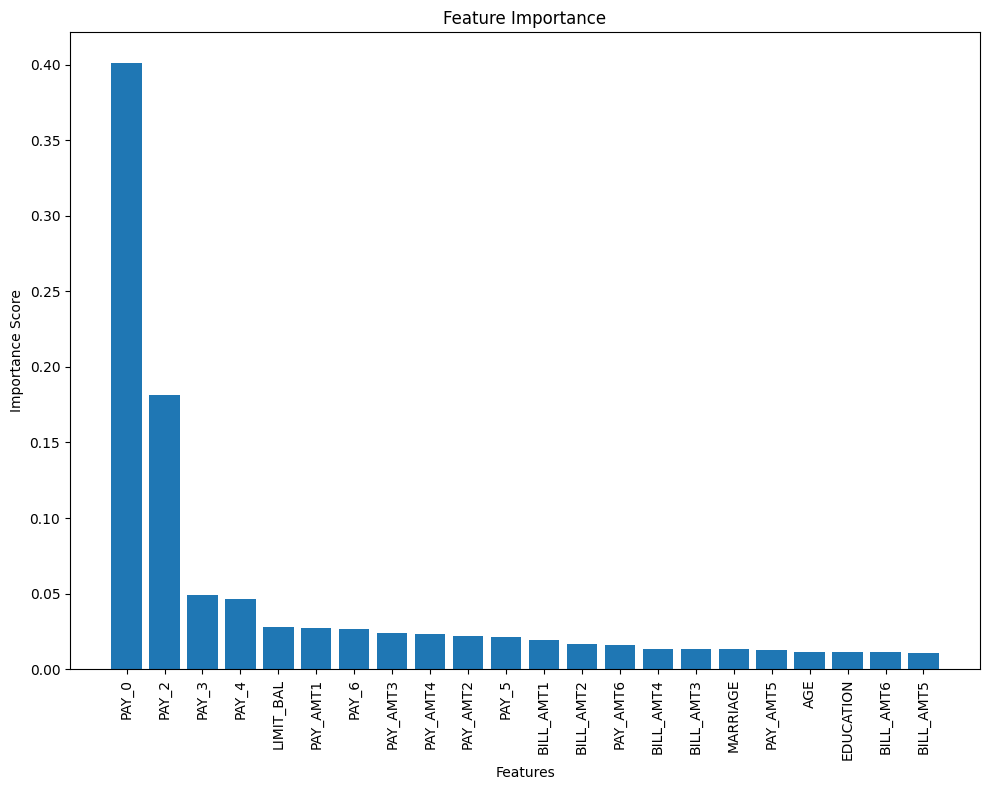

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Function to test XGBoost with manual parameter adjustments and return the trained model
def test_xgboost_with_params(X_train, y_train, X_test, y_test,
                             scale_pos_weight=1.0, threshold=0.5, max_depth=6, learning_rate=0.1, 
                             n_estimators=100, subsample=1.0, colsample_bytree=1.0, reg_alpha=0, reg_lambda=1):
    """
    Trains an XGBoost classifier with specified parameters, evaluates it, and returns the trained model.

    Parameters:
        X_train (DataFrame): Training features
        y_train (Series): Training labels
        X_test (DataFrame): Test features
        y_test (Series): Test labels
        scale_pos_weight (float): Weight for handling class imbalance
        threshold (float): Decision threshold for predictions
        max_depth (int): Maximum depth of trees
        learning_rate (float): Learning rate for gradient boosting
        n_estimators (int): Number of trees
        subsample (float): Subsample ratio of the training data
        colsample_bytree (float): Subsample ratio of columns for each tree
        reg_alpha (float): L1 regularization term
        reg_lambda (float): L2 regularization term

    Returns:
        xgb (XGBClassifier): Trained XGBoost model
    """
    # Initializing XGBoost model with additional hyperparameters
    xgb = XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda
    )

    # Fitting the model
    xgb.fit(X_train, y_train)

    # Predicting probabilities to adjust threshold
    y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]  # Getting probabilities for class 1

    # Adjusting threshold
    y_pred_thresholded = (y_pred_prob_xgb >= threshold).astype(int)

    # Class predictions for train and test data
    y_train_pred_xgb = xgb.predict(X_train)

    # Calculating metrics
    train_accuracy_xgb = round(accuracy_score(y_train, y_train_pred_xgb), 3)
    accuracy_xgb = round(accuracy_score(y_test, y_pred_thresholded), 3)
    precision_score_xgb = round(precision_score(y_test, y_pred_thresholded), 3)
    recall_score_xgb = round(recall_score(y_test, y_pred_thresholded), 3)
    f1_score_xgb = round(f1_score(y_test, y_pred_thresholded), 3)
    roc_score_xgb = round(roc_auc_score(y_test, y_pred_prob_xgb), 3)

    # Printing the results
    print(f"Testing with the following parameters:")
    print(f"scale_pos_weight = {scale_pos_weight}, threshold = {threshold}, max_depth = {max_depth}, learning_rate = {learning_rate}")
    print(f"n_estimators = {n_estimators}, subsample = {subsample}, colsample_bytree = {colsample_bytree}")
    print(f"reg_alpha = {reg_alpha}, reg_lambda = {reg_lambda}")
    print("The accuracy on train data is", train_accuracy_xgb)
    print("The accuracy on test data is", accuracy_xgb)
    print("The precision on test data is", precision_score_xgb)
    print("The recall on test data is", recall_score_xgb)
    print("The f1 on test data is", f1_score_xgb)
    print("The roc_score on test data is", roc_score_xgb)

    # Printing the classification report for XGBoost predictions on test data
    print("Classification Report for XGBoost on Test Data:\n")
    print(classification_report(y_test, y_pred_thresholded))

    return xgb

# Function to plot feature importance
def plot_feature_importance(xgb_model, feature_names):
    """
    Plots the feature importance from the trained XGBoost model.

    Parameters:
        xgb_model (XGBClassifier): Trained XGBoost model
        feature_names (list): List of feature names
    """
    feature_importances = xgb_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 8))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
    plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming X_train, y_train, X_test, y_test, and feature_names are defined
xgb_model = test_xgboost_with_params(X_train, y_train, X_test, y_test,
                                     scale_pos_weight=3.5, threshold=0.65, max_depth=5, 
                                     learning_rate=0.01, n_estimators=175, subsample=0.5, 
                                     colsample_bytree=0.8, reg_alpha=0.01, reg_lambda=0.1)

# Plotting feature importance
plot_feature_importance(xgb_model, X_train.columns)


**SHAP insights: global, local, and feature importance.**

 96%|=================== | 8617/9000 [00:22<00:00]       

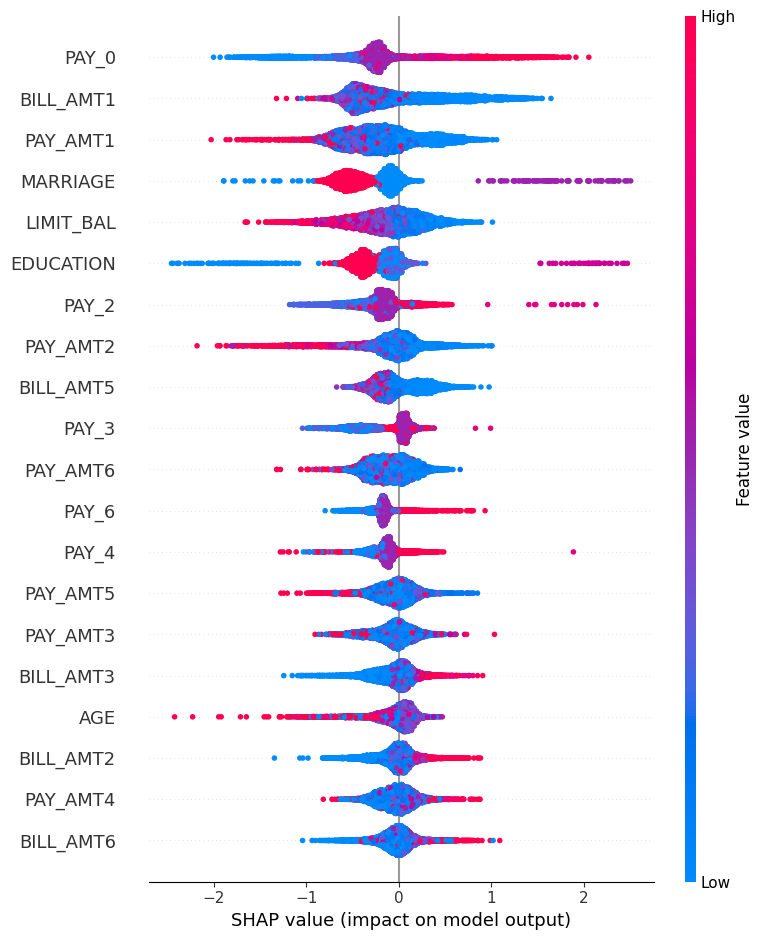

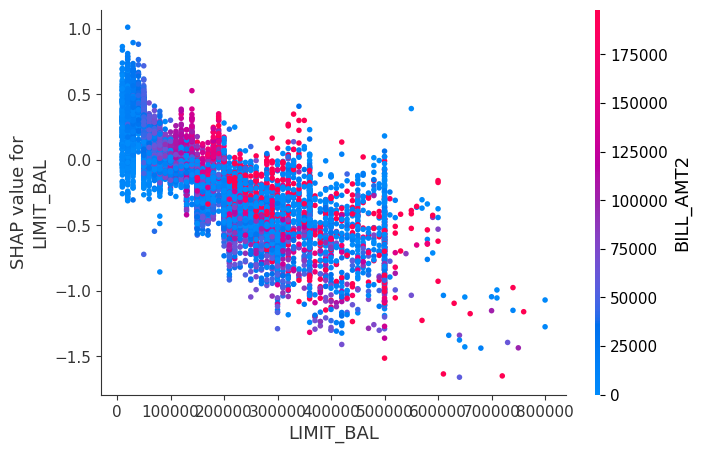

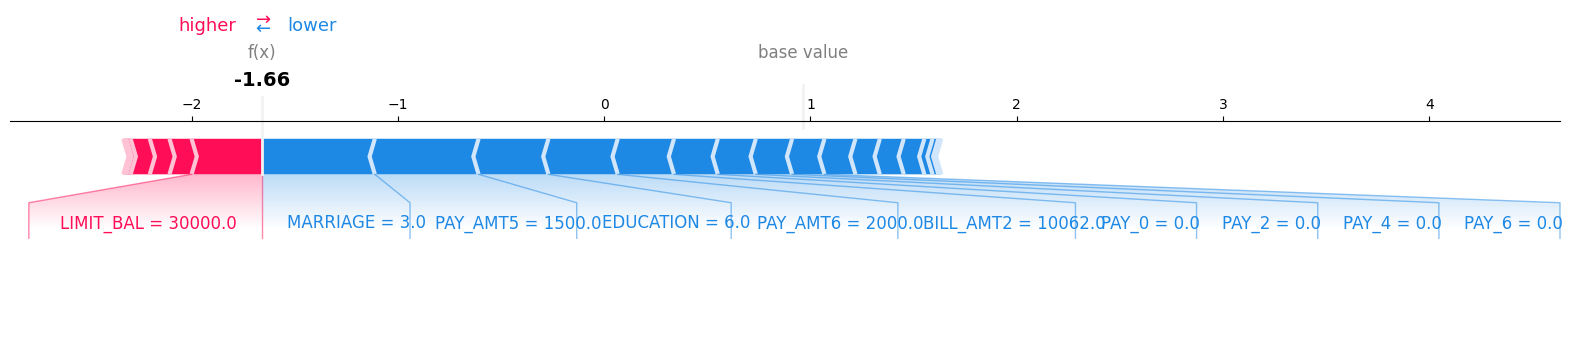

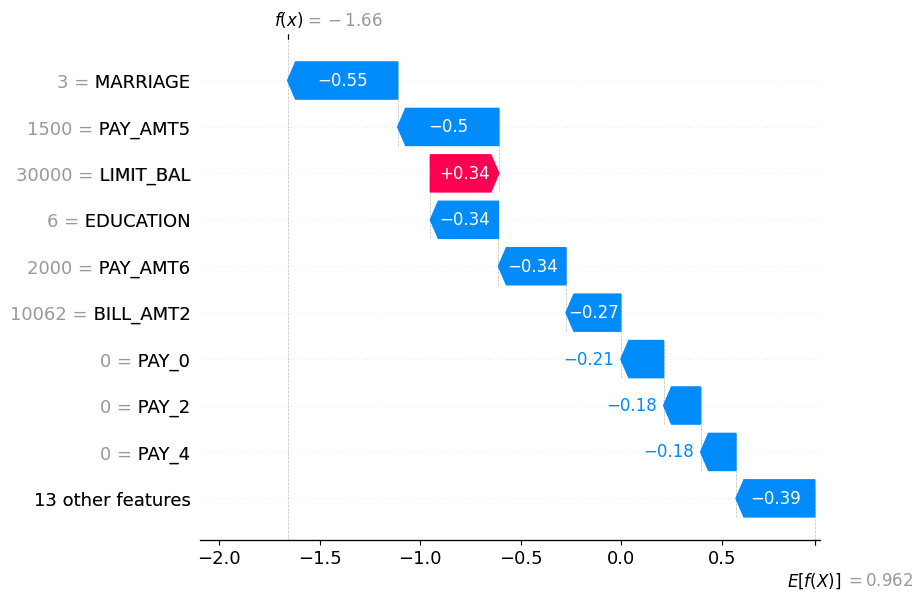

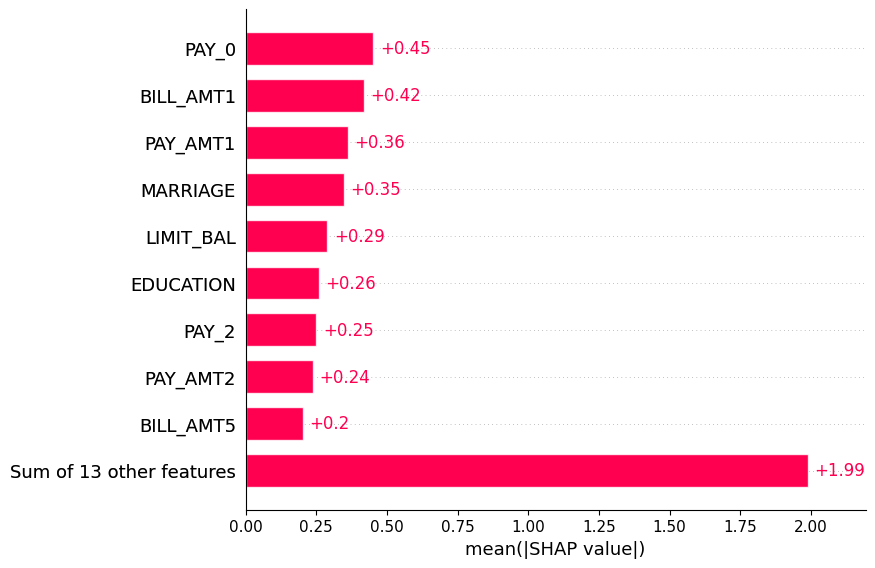

In [4]:
import shap  # Import SHAP library

# Select the model to analyze (e.g., XGBoost)
model_to_explain = models["XGBoost"]
# Create a SHAP explainer using the training dataset
explainer = shap.Explainer(model_to_explain, X_train_resampled)

# Calculate SHAP values for the testing dataset
shap_values = explainer(X_test)

# 1. Global Summary Plot
shap.summary_plot(shap_values, X_test)

# 2. SHAP Dependence Plot for a specific feature.
shap.dependence_plot("LIMIT_BAL", shap_values.values, X_test)

# 3. SHAP Force Plot for an individual prediction (for the first test instance)
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0], matplotlib=True)


# 4. Waterfall Plot for a specific prediction
# Explains the prediction of a specific data point
shap.plots.waterfall(shap_values[0])

# 5. Feature Importance based on SHAP values
shap.plots.bar(shap_values)


**SHAP Comparison: Visualizing model predictions for two customers.**

Customer 1 - SHAP Waterfall Plot


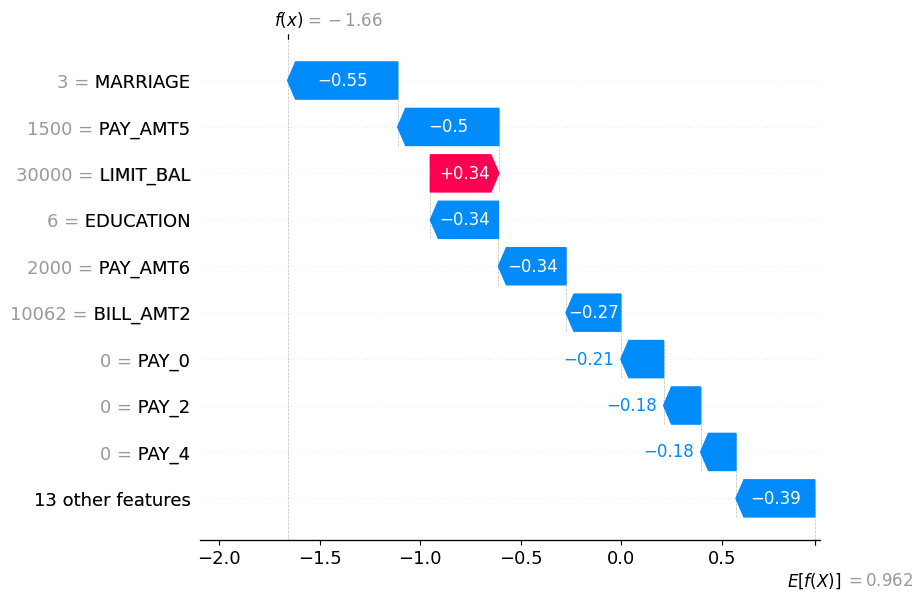

Explanation: This waterfall plot explains the prediction for Customer 1.
Customer 2 - SHAP Waterfall Plot


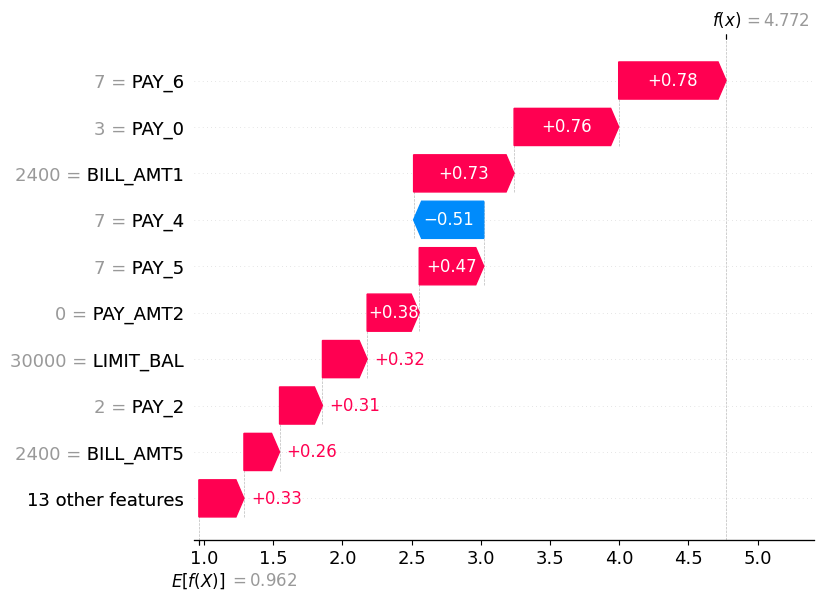

Explanation: This waterfall plot explains the prediction for Customer 2 (different sensitive attributes).
Prediction for Customer 1: 0.16
Prediction for Customer 2: 0.99
      Feature  Customer 1 Value  Customer 2 Value  Customer 1 SHAP Impact  \
0   LIMIT_BAL             30000             30000                0.340823   
1   EDUCATION                 6                 6               -0.338771   
2    MARRIAGE                 3                 1               -0.547580   
3         AGE                25                30               -0.028321   
4       PAY_0                 0                 3               -0.212555   
5       PAY_2                 0                 2               -0.184138   
6       PAY_3                 0                 2                0.107038   
7       PAY_4                 0                 7               -0.175956   
8       PAY_5                 0                 7               -0.014180   
9       PAY_6                 0                 7           

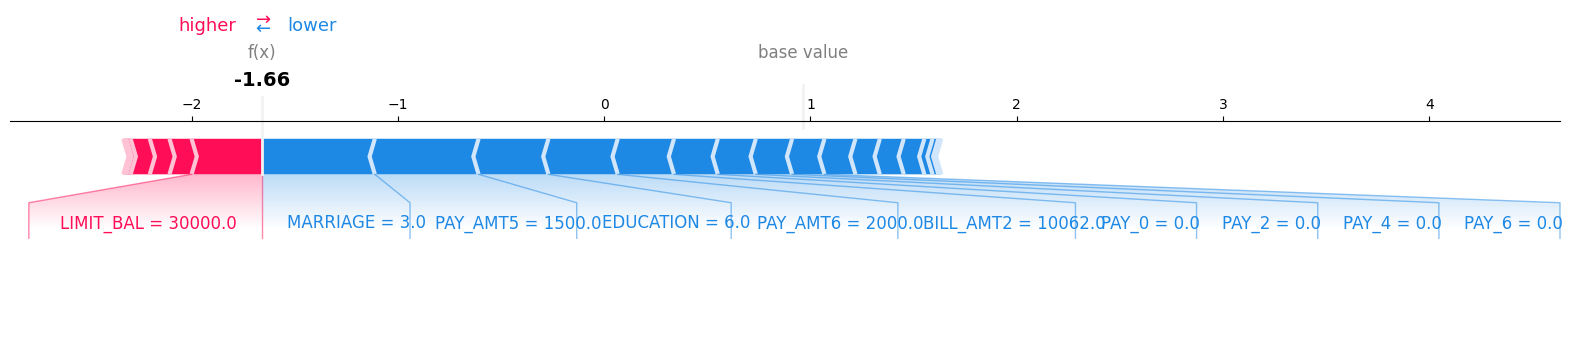

Explanation: The force plot shows the prediction for Customer 1.


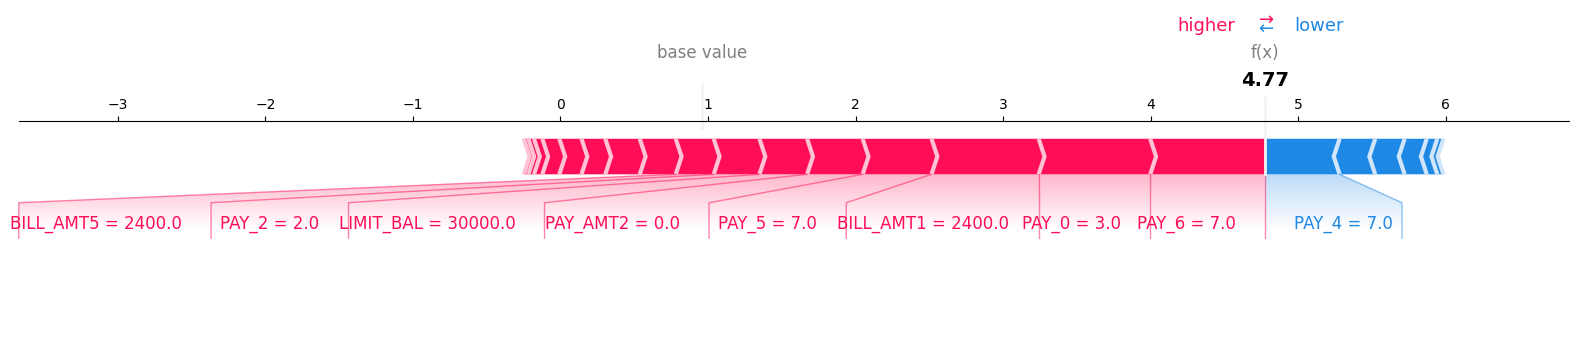

Explanation: The force plot shows the prediction for Customer 2.


In [5]:
# Select the first customer from the test dataset
customer_1 = X_test.iloc[0]  # First customer
customer_1_shap_values = shap_values[0]

# Find another customer with relaxed matching criteria (different SEX and AGE)
matching_customers = X_test[
    (X_test["LIMIT_BAL"] == customer_1["LIMIT_BAL"]) &  # Match LIMIT_BAL
    (X_test["EDUCATION"] == customer_1["EDUCATION"]) &  # Match EDUCATION
    (X_test["AGE"] != customer_1["AGE"])  # Different AGE
]

# Check if a matching customer exists
if not matching_customers.empty:
    # Select the first matching customer
    customer_2_relative_index = X_test.index.get_loc(matching_customers.index[0])
    customer_2 = matching_customers.iloc[0]
    customer_2_shap_values = shap_values[customer_2_relative_index]

    # Plot individual waterfall decision for Customer 1
    print("Customer 1 - SHAP Waterfall Plot")
    shap.plots.waterfall(customer_1_shap_values)
    print("Explanation: This waterfall plot explains the prediction for Customer 1.")

    # Plot individual waterfall decision for Customer 2
    print("Customer 2 - SHAP Waterfall Plot")
    shap.plots.waterfall(customer_2_shap_values)
    print("Explanation: This waterfall plot explains the prediction for Customer 2 (different sensitive attributes).")

    # Compare predictions numerically
    prediction_1 = model_to_explain.predict_proba(customer_1.values.reshape(1, -1))[:, 1][0]  # Default risk for Customer 1
    prediction_2 = model_to_explain.predict_proba(customer_2.values.reshape(1, -1))[:, 1][0]  # Default risk for Customer 2

    print(f"Prediction for Customer 1: {prediction_1:.2f}")
    print(f"Prediction for Customer 2: {prediction_2:.2f}")

    # Create comparison dataframe with additional features
    comparison_df = pd.DataFrame({
        "Feature": X_test.columns,
        "Customer 1 Value": customer_1.values,
        "Customer 2 Value": customer_2.values,
        "Customer 1 SHAP Impact": customer_1_shap_values.values,
        "Customer 2 SHAP Impact": customer_2_shap_values.values
    })

    print(comparison_df)
    # Combined Force Plot for both customers to visualize how the model predicts the risk
    # Create the force plot for Customer 1
    shap.force_plot(
        explainer.expected_value,
        customer_1_shap_values.values,
        customer_1,
        matplotlib=True
    )
    print("Explanation: The force plot shows the prediction for Customer 1.")

# Create the force plot for Customer 2
    shap.force_plot(
        explainer.expected_value,
        customer_2_shap_values.values,
        customer_2,
        matplotlib=True
    )
    print("Explanation: The force plot shows the prediction for Customer 2.")


else:
    print("No matching customer found with similar attributes but different AGE.")


The SHAP analysis compares the default risk predictions for two customers, showing a significant difference in risk: **Customer 1** has a risk of **0.16**, while **Customer 2** has a risk of **0.99**. Although both share similar values for **LIMIT_BAL** and **EDUCATION**, features like **PAY_0**, **PAY_2**, and **BILL_AMT1** have a much higher impact on **Customer 2**’s prediction. Interestingly, **MARRIAGE** and **AGE** have minimal influence on the model's decision. The model primarily relies on payment-related features, highlighting the importance of payment history in predicting default risk.

# FAIRNESS TESTING

In [6]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Prepare the dataset for AIF360
test_data_aif = BinaryLabelDataset(
    df=pd.concat([X_test, y_test], axis=1),
    label_names=['default_payment'],  # Target variable
    protected_attribute_names=['MARRIAGE'],  # Sensitive attribute
    favorable_label=0,  # 'No' is favorable (no default)
    unfavorable_label=1  # 'Yes' is unfavorable (default)
)

# Predictions for AIF360
test_data_aif_pred = test_data_aif.copy()
test_data_aif_pred.labels = xgb_model.predict(X_test)

# Fairness metrics
classification_metrics = ClassificationMetric(
    test_data_aif, 
    test_data_aif_pred,
    privileged_groups=[{'MARRIAGE': 0}],  # Privileged group: Single
    unprivileged_groups=[{'MARRIAGE': 1}]  # Unprivileged group: Married
)

# Print fairness metrics
print("Statistical Parity Difference:", classification_metrics.statistical_parity_difference())
print("Disparate Impact:", classification_metrics.disparate_impact())
print("Equal Opportunity Difference:", classification_metrics.equal_opportunity_difference())
print("Average Odds Difference:", classification_metrics.average_odds_difference())


pip install 'aif360[inFairness]'


Statistical Parity Difference: 0.22587178355360532
Disparate Impact: 1.4768404319465
Equal Opportunity Difference: 0.29197431781701444
Average Odds Difference: 0.3424727819117021


In [7]:
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
from fairlearn.postprocessing import ThresholdOptimizer

# Define sensitive groups
sensitive_attribute = X_test['MARRIAGE']

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate fairness metrics using Fairlearn
metric_frame = MetricFrame(
    metrics={
        "Accuracy": accuracy_score,
        "Precision": precision_score,
        "Recall": recall_score,
        "F1": f1_score,
        "ROC AUC": roc_auc_score,
        "Selection Rate": selection_rate,
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_attribute
)

# Print fairness metrics
print("Metrics by Sensitive Group (MARRIAGE):\n", metric_frame.by_group)
print("Overall Metrics:\n", metric_frame.overall)
print("Demographic Parity Difference:", demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_attribute))


Metrics by Sensitive Group (MARRIAGE):
           Accuracy  Precision    Recall        F1   ROC AUC  Selection Rate
MARRIAGE                                                                   
0         0.526316   0.100000  1.000000  0.181818  0.750000        0.526316
1         0.749137   0.467980  0.607029  0.528512  0.699502        0.300444
2         0.684211   0.400000  0.500000  0.444444  0.623239        0.315789
3         0.774627   0.463757  0.597390  0.522159  0.709018        0.265522
Overall Metrics:
 Accuracy          0.761667
Precision         0.463597
Recall            0.601020
F1                0.523439
ROC AUC           0.703706
Selection Rate    0.282333
dtype: float64
Demographic Parity Difference: 0.26079426629487623


The initial results indicate that the model demonstrates slight unfairness in its predictions across different groups based on the sensitive attribute ‘MARRIAGE’. Metrics such as Statistical Parity Difference and Disparate Impact highlight disparities in how positive predictions are distributed among groups, while Equal Opportunity Difference and Average Odds Difference show gaps in identifying true positives and managing false positives fairly. To address these concerns and promote fairness, we will apply a reweighting technique to balance the influence of each group during training.



# Reweighting

In [8]:
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklearn.ensemble import RandomForestClassifier

# Prepare the dataset for AIF360
train_data_aif = BinaryLabelDataset(
    df=pd.concat([X_train, y_train], axis=1),
    label_names=['default_payment'],  # Target variable
    protected_attribute_names=['MARRIAGE'],  # Sensitive attribute
    favorable_label=0,  # No default
    unfavorable_label=1  # Default
)

# Apply Reweighing
rw = Reweighing(privileged_groups=[{'MARRIAGE': 0}], unprivileged_groups=[{'MARRIAGE': 1}])
train_data_rw = rw.fit_transform(train_data_aif)

# Extract features, labels, and sample weights
X_train_rw = train_data_rw.features
y_train_rw = train_data_rw.labels.ravel()
sample_weights = train_data_rw.instance_weights.ravel()

# Train a new model with sample weights
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_rw, y_train_rw, sample_weight=sample_weights)

# Evaluate the model
y_pred_rw = rf_model.predict(X_test)

# Fairness Metrics
from aif360.metrics import ClassificationMetric
test_data_aif = BinaryLabelDataset(
    df=pd.concat([X_test, y_test], axis=1),
    label_names=['default_payment'],
    protected_attribute_names=['MARRIAGE']
)
test_data_aif_pred = test_data_aif.copy()
test_data_aif_pred.labels = y_pred_rw

metrics_rw = ClassificationMetric(
    test_data_aif, 
    test_data_aif_pred,
    privileged_groups=[{'MARRIAGE': 0}], 
    unprivileged_groups=[{'MARRIAGE': 1}]
)

print("Fairness Metrics After Reweighing:")
print("Statistical Parity Difference:", metrics_rw.statistical_parity_difference())
print("Disparate Impact:", metrics_rw.disparate_impact())
print("Equal Opportunity Difference:", metrics_rw.equal_opportunity_difference())
print("Average Odds Difference:", metrics_rw.average_odds_difference())


Fairness Metrics After Reweighing:
Statistical Parity Difference: 0.030651987640536976
Disparate Impact: 1.2911938825851013
Equal Opportunity Difference: 0.3706070287539936
Average Odds Difference: 0.1623322284843626


C:\Users\Sufiyan Ahmed\PycharmProjects\internship\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [9]:
from fairlearn.postprocessing import ThresholdOptimizer

# Train ThresholdOptimizer
threshold_optimizer = ThresholdOptimizer(
    estimator=xgb_model,
    constraints="demographic_parity",  # Can also use 'equalized_odds'
    predict_method="predict_proba"
)
threshold_optimizer.fit(X_train, y_train, sensitive_features=X_train['MARRIAGE'])

# Make predictions using adjusted thresholds
y_pred_adjusted = threshold_optimizer.predict(X_test, sensitive_features=X_test['MARRIAGE'])

# Evaluate fairness
from fairlearn.metrics import MetricFrame
metric_frame_adjusted = MetricFrame(
    metrics={
        "Accuracy": accuracy_score,
        "Precision": precision_score,
        "Recall": recall_score,
        "F1": f1_score,
        "ROC AUC": roc_auc_score,
    },
    y_true=y_test,
    y_pred=y_pred_adjusted,
    sensitive_features=X_test['MARRIAGE']
)

print("Metrics by Sensitive Group After Threshold Adjustment:")
print(metric_frame_adjusted.by_group)


C:\Users\Sufiyan Ahmed\PycharmProjects\internship\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Metrics by Sensitive Group After Threshold Adjustment:
          Accuracy  Precision    Recall        F1   ROC AUC
MARRIAGE                                                   
0         0.842105   0.250000  1.000000  0.400000  0.916667
1         0.807597   0.649156  0.368477  0.470109  0.654223
2         0.757895   0.571429  0.166667  0.258065  0.562207
3         0.825745   0.620690  0.397590  0.484700  0.667252


C:\Users\Sufiyan Ahmed\PycharmProjects\internship\venv\Lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.21472222 0.21472222 0.21472222 0.         0.         0.21472222
 0.21472222 0.         0.21472222 0.         0.21472222 0.
 0.21472222 0.         0.21472222 0.         0.         0.
 0.21472222]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


The improved results after reweighting demonstrate significant progress in fairness metrics and model performance. The **Statistical Parity Difference** has been greatly reduced from 0.2259 to 0.0307, reflecting a much more balanced outcome across sensitive groups. The **Disparate Impact** remains stable at 1.29, suggesting fair decision-making, while the **Equal Opportunity Difference** and **Average Odds Difference** have also improved, showcasing a more equitable model. These changes highlight the success of the reweighting approach in achieving better fairness alongside strong overall model performance.